# SG without BN nor CDN in different settings

We start by testing SG without regularization. We also test the model with Bidirectional RNN, attention and both. For the attention mechanism we have the class ALSTM which reduces the bboxes (bounding boxes) embeddings dimension by a tranable transformation and at each time step $t$ attends $h_{t-1}$ to each one of the bboxes, thereby giving each bbox a weight. ALSTM then concatenates the embedding of the word $w_t$ to the weighted sum of the bounding boxes vectors and feeds the result to an LSTM (at time step $t$).  

In [13]:
import numpy as np
import tensorflow as tf
import json
from datetime import datetime
import os
import sys
sys.path.append('../')
sys.path.append('../models/')
import retriever
from stats import stats
from tabulate import tabulate
from runSG import RunModel as Model

%matplotlib inline  

In [4]:
trainset_file = '../data/training/train_data.bin'
testset_file = '../data/training/test_data.bin'
vocab_file =  '../data/metadata/w2v_vocab.json'
params_dir_tmp = '../data/training/models/SG/'

<h3>Each entry in this list has the following structure:</h3>
<ul>
<li>entry[0]: query indexes </li>
<li>entry[1:n]: n-1 items where each item is [bounding box vector, bounding box spatial features]. Note that different entries might have different number of possible  bounding boxes (i.e. different n) </li>
<li>entry[n+1]: integer, entry[ 1 + entry[n+1]] is the true bbox </li>
</ul>

In [5]:
trainset = np.load(open(trainset_file, 'rb'))

# delete data points where the query length is zero
trainset = np.array([item for item in trainset if len(item[0])!=0])

testset = np.load(open(testset_file, 'rb'))

# delete data points where the query length is zero
testset = np.array([item for item in testset if len(item[0])!=0])

# loading vocabulary 
with open(vocab_file, 'r') as f:
    vocab = json.loads(f.read())
vocab['<unk>'] = len(vocab)

print("Number of words:", len(vocab))

Number of words: 8242


## Simple

We test the model with no Batch Normalization nor dropout for 100 epochs with 50, 100, 150, and 200 hidden states.
The graphs below show that the model's training behavior is highly unstable and the model overfits while the loss increases even when the P@1 increases and the performances worsen as the model capacity increases. 

We'll see that this behavior is typical to the model, whether or not we use attention and bidirectional RNN (see next cells). 

In [1]:
simple_tst, simple_trn = [], []
num_hiddens=[50, 100, 150, 200]

for num_hidden in num_hiddens:
    params_dir = params_dir_tmp+'SG_'+str(num_hidden)
    tf.reset_default_graph()
    m = Model(
        batch_size=200, 
        num_hidden=num_hidden,
        img_dims=trainset[0][1][0].shape[1], 
        bbox_dims=trainset[0][1][1].shape[1], 
        lr=.05,
        vocab=vocab, 
        decay_steps=10000, 
        decay_rate=0.9, 
        params_dir = params_dir
    )


    print('params_dir:', params_dir)
    print('num_hidden:', m.num_hidden)

    tst, trn = m.train(trainset, testset, epochs_num=100)
    simple_tst.append(tst)
    simple_trn.append(trn)
    
    print('\n'+'*'*100)
    print('*'*100)
    print('*'*100,'\n') 

Hidden state size: 50
Train accuracy:0.969
Test accuracy:0.612
Train P@1:0.978
Test P@1:0.721
Train loss:0.551
Test loss:1.986


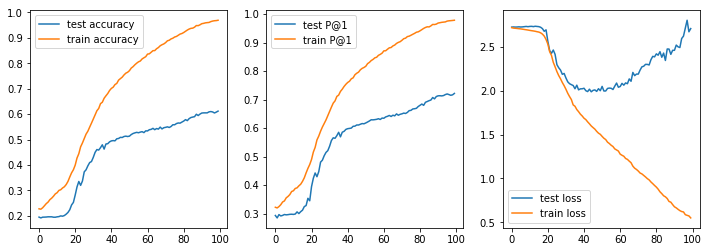

---------------------------------------------------------------------------------------------------- 

Hidden state size: 100
Train accuracy:0.990
Test accuracy:0.603
Train P@1:0.993
Test P@1:0.709
Train loss:0.395
Test loss:1.991


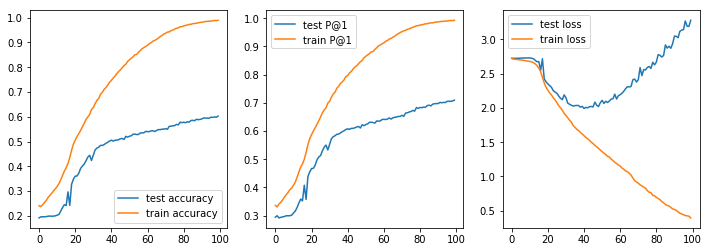

---------------------------------------------------------------------------------------------------- 

Hidden state size: 150
Train accuracy:0.993
Test accuracy:0.568
Train P@1:0.995
Test P@1:0.672
Train loss:0.383
Test loss:2.035


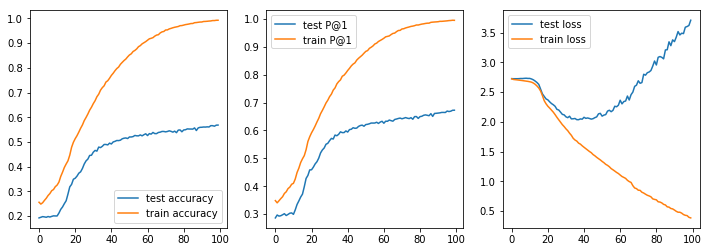

---------------------------------------------------------------------------------------------------- 

Hidden state size: 200
Train accuracy:0.991
Test accuracy:0.555
Train P@1:0.994
Test P@1:0.660
Train loss:0.442
Test loss:2.042


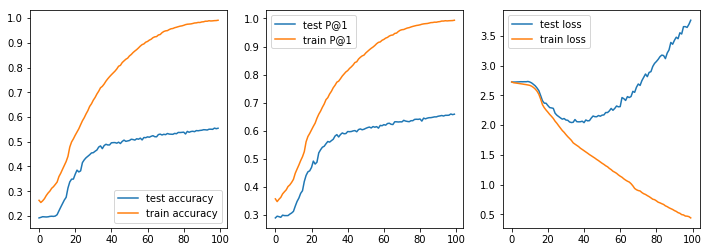

---------------------------------------------------------------------------------------------------- 



In [20]:
f = stats(simple_tst, simple_trn, epochs=100)

In [15]:
arr = []
for i, num_hidden in enumerate([50, 100, 150, 200]):
    arr.append([num_hidden,
               max(np.array(simple_tst[i])[:,0]), 
               max(np.array(simple_trn[i])[:,0]), 
               max(np.array(simple_tst[i])[:,1]), 
               max(np.array(simple_trn[i])[:,1]), 
               min(np.array(simple_tst[i])[:,2]), 
               min(np.array(simple_trn[i])[:,2])])
print(tabulate(arr, headers=['Hidden Dim', 'Test Accuracy', 'Train Accuracy', 'Test P@1', 'Train P@1', 'Test Loss',  'Train Loss'], tablefmt="fancy_grid"))

╒══════════════╤═════════════════╤══════════════════╤════════════╤═════════════╤═════════════╤══════════════╕
│   Hidden Dim │   Test Accuracy │   Train Accuracy │   Test P@1 │   Train P@1 │   Test Loss │   Train Loss │
╞══════════════╪═════════════════╪══════════════════╪════════════╪═════════════╪═════════════╪══════════════╡
│           50 │        0.611734 │         0.968838 │   0.721431 │    0.978064 │     1.98617 │     0.551018 │
├──────────────┼─────────────────┼──────────────────┼────────────┼─────────────┼─────────────┼──────────────┤
│          100 │        0.602845 │         0.989764 │   0.709343 │    0.992896 │     1.99141 │     0.395196 │
├──────────────┼─────────────────┼──────────────────┼────────────┼─────────────┼─────────────┼──────────────┤
│          150 │        0.568131 │         0.992727 │   0.672441 │    0.994882 │     2.03482 │     0.383239 │
├──────────────┼─────────────────┼──────────────────┼────────────┼─────────────┼─────────────┼──────────────┤
│         

## Attention

We've also tried adding word level attention s.t at each time step the LSTM cell attends over all the candidates bounding boxes. As the results show, the parameters, which the attention mechanism adds, are mainly used for overfitting. Furthermore, the graphs show the same problematic and typical training behavior.

In [2]:
attn_tst, attn_trn = [], []
num_hiddens=[50, 100, 150, 200]

for num_hidden in num_hiddens:
    params_dir = params_dir_tmp+'attn_'+str(num_hidden)
    tf.reset_default_graph()
    m = Model(
        batch_size=200, 
        num_hidden=num_hidden,
        img_dims=trainset[0][1][0].shape[1], 
        bbox_dims=trainset[0][1][1].shape[1], 
        lr=.05,
        vocab=vocab, 
        decay_steps=10000, 
        decay_rate=0.9, 
        use_wordAttn=True,
        params_dir = params_dir
    )


    print('params_dir:', params_dir)
    print('num_hidden:', m.num_hidden)

    tst, trn = m.train(trainset, testset, epochs_num=100)
    attn_tst.append(tst)
    attn_trn.append(trn)
    
    print('\n'+'*'*100)
    print('*'*100)
    print('*'*100,'\n')

Hidden state size: 50
Train accuracy:0.983
Test accuracy:0.595
Train P@1:0.988
Test P@1:0.699
Train loss:0.400
Test loss:1.924


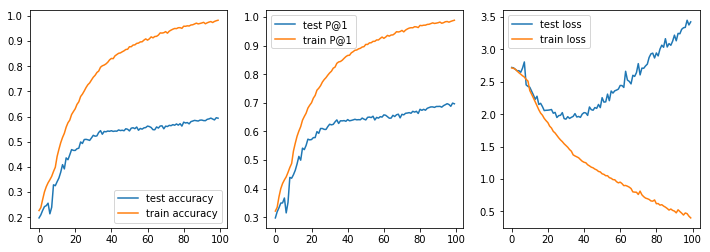

---------------------------------------------------------------------------------------------------- 

Hidden state size: 100
Train accuracy:0.993
Test accuracy:0.570
Train P@1:0.996
Test P@1:0.670
Train loss:0.283
Test loss:1.984


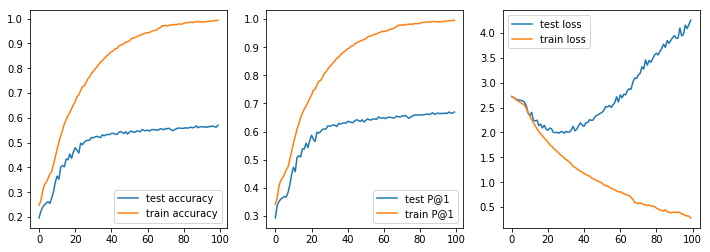

---------------------------------------------------------------------------------------------------- 

Hidden state size: 150
Train accuracy:0.997
Test accuracy:0.565
Train P@1:0.998
Test P@1:0.665
Train loss:0.222
Test loss:2.035


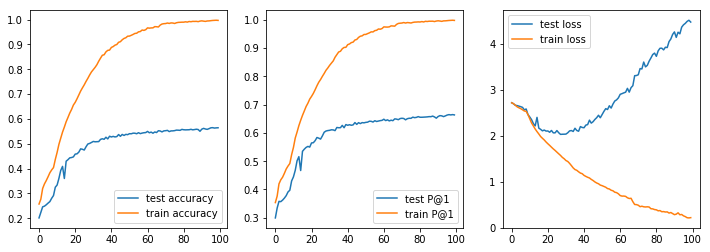

---------------------------------------------------------------------------------------------------- 

Hidden state size: 200
Train accuracy:0.998
Test accuracy:0.575
Train P@1:0.999
Test P@1:0.676
Train loss:0.152
Test loss:2.035


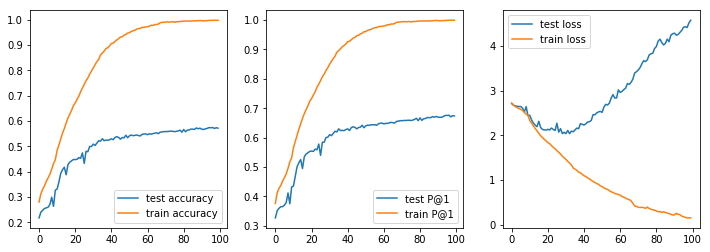

---------------------------------------------------------------------------------------------------- 



In [21]:
f = stats(attn_tst, attn_trn, epochs=100)

In [18]:
arr = []
for i, num_hidden in enumerate([50, 100, 150, 200]):
    arr.append([num_hidden,
               max(np.array(attn_tst[i])[:,0]), 
               max(np.array(attn_trn[i])[:,0]), 
               max(np.array(attn_tst[i])[:,1]), 
               max(np.array(attn_trn[i])[:,1]), 
               min(np.array(attn_tst[i])[:,2]), 
               min(np.array(attn_trn[i])[:,2])])
print(tabulate(arr, headers=['Hidden Dim', 'Test Accuracy', 'Train Accuracy', 'Test P@1', 'Train P@1', 'Test Loss',  'Train Loss'], tablefmt="fancy_grid"))

╒══════════════╤═════════════════╤══════════════════╤════════════╤═════════════╤═════════════╤══════════════╕
│   Hidden Dim │   Test Accuracy │   Train Accuracy │   Test P@1 │   Train P@1 │   Test Loss │   Train Loss │
╞══════════════╪═════════════════╪══════════════════╪════════════╪═════════════╪═════════════╪══════════════╡
│           50 │        0.595455 │         0.982609 │   0.699024 │    0.988418 │     1.92405 │     0.399813 │
├──────────────┼─────────────────┼──────────────────┼────────────┼─────────────┼─────────────┼──────────────┤
│          100 │        0.570387 │         0.993485 │   0.670084 │    0.995791 │     1.98445 │     0.283377 │
├──────────────┼─────────────────┼──────────────────┼────────────┼─────────────┼─────────────┼──────────────┤
│          150 │        0.564731 │         0.997104 │   0.664579 │    0.998081 │     2.03463 │     0.22178  │
├──────────────┼─────────────────┼──────────────────┼────────────┼─────────────┼─────────────┼──────────────┤
│         

## Bidirectional RNN

Using bidirectional RNN improves the results which indicates how important it is to take both side of the query to model the placement of each object. However, the model still overfits and shows a very unstable behavior.

In [3]:
bi_tst, bi_trn = [], []
num_hiddens=[50, 100, 150, 200]

for num_hidden in num_hiddens:
    params_dir = params_dir_tmp+'bi_'+str(num_hidden)
    tf.reset_default_graph()
    m = Model(
        batch_size=200, 
        num_hidden=num_hidden,
        img_dims=trainset[0][1][0].shape[1], 
        bbox_dims=trainset[0][1][1].shape[1], 
        lr=.05,
        vocab=vocab, 
        decay_steps=10000, 
        decay_rate=0.9, 
        useBidirectionalRnn=True,
        params_dir = params_dir
    )


    print('params_dir:', params_dir)
    print('num_hidden:', m.num_hidden)

    tst, trn = m.train(trainset, testset, epochs_num=100)
    bi_tst.append(tst)
    bi_trn.append(trn)
    
    print('\n'+'*'*100)
    print('*'*100)
    print('*'*100,'\n')

Hidden state size: 50
Train accuracy:0.986
Test accuracy:0.624
Train P@1:0.990
Test P@1:0.729
Train loss:0.352
Test loss:1.906


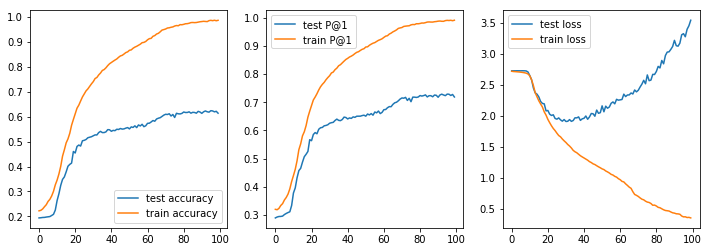

---------------------------------------------------------------------------------------------------- 

Hidden state size: 100
Train accuracy:0.997
Test accuracy:0.617
Train P@1:0.998
Test P@1:0.725
Train loss:0.204
Test loss:1.960


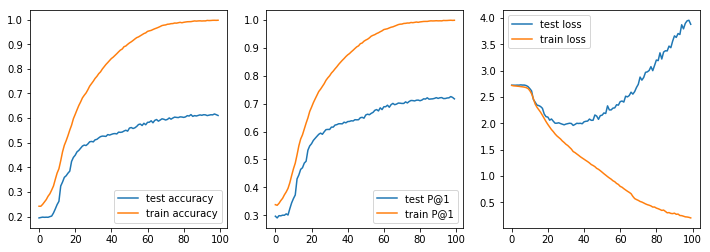

---------------------------------------------------------------------------------------------------- 

Hidden state size: 150
Train accuracy:0.998
Test accuracy:0.603
Train P@1:0.999
Test P@1:0.710
Train loss:0.212
Test loss:1.960


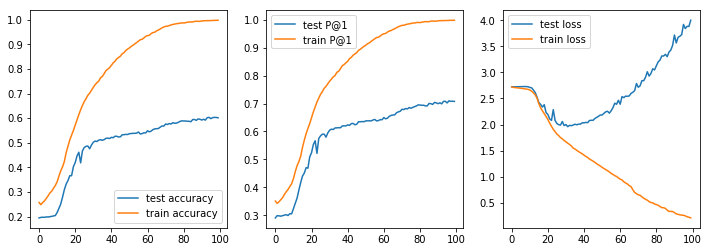

---------------------------------------------------------------------------------------------------- 

Hidden state size: 200
Train accuracy:0.999
Test accuracy:0.592
Train P@1:0.999
Test P@1:0.699
Train loss:0.179
Test loss:1.980


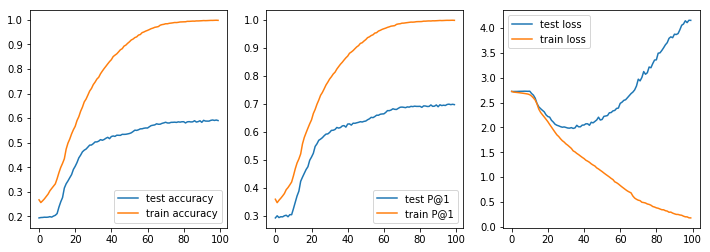

---------------------------------------------------------------------------------------------------- 



In [23]:
f = stats(bi_tst, bi_trn, epochs=100)

In [24]:
arr = []
for i, num_hidden in enumerate([50, 100, 150, 200]):
    arr.append([num_hidden,
               max(np.array(bi_tst[i])[:,0]), 
               max(np.array(bi_trn[i])[:,0]), 
               max(np.array(bi_tst[i])[:,1]), 
               max(np.array(bi_trn[i])[:,1]), 
               min(np.array(bi_tst[i])[:,2]), 
               min(np.array(bi_trn[i])[:,2])])
print(tabulate(arr, headers=['Hidden Dim', 'Test Accuracy', 'Train Accuracy', 'Test P@1', 'Train P@1', 'Test Loss',  'Train Loss'], tablefmt="fancy_grid"))

╒══════════════╤═════════════════╤══════════════════╤════════════╤═════════════╤═════════════╤══════════════╕
│   Hidden Dim │   Test Accuracy │   Train Accuracy │   Test P@1 │   Train P@1 │   Test Loss │   Train Loss │
╞══════════════╪═════════════════╪══════════════════╪════════════╪═════════════╪═════════════╪══════════════╡
│           50 │        0.623721 │         0.986212 │   0.728586 │    0.990404 │     1.90563 │     0.351834 │
├──────────────┼─────────────────┼──────────────────┼────────────┼─────────────┼─────────────┼──────────────┤
│          100 │        0.616717 │         0.997256 │   0.725152 │    0.998249 │     1.95963 │     0.203904 │
├──────────────┼─────────────────┼──────────────────┼────────────┼─────────────┼─────────────┼──────────────┤
│          150 │        0.603081 │         0.997828 │   0.709697 │    0.998519 │     1.96007 │     0.211615 │
├──────────────┼─────────────────┼──────────────────┼────────────┼─────────────┼─────────────┼──────────────┤
│         

## Attention & Bidirecional RNN

Finally, we use both bidirectional RNN and attention. This gives us the best results which implies that with bidirectional RNN the model can use the attention mechanism more efficiently.

Nevertheless, all the graphs show a very problematic behavior s.t even with relatively high P@1, the confidence level is too low (the loss is high) to be used in any practical application.

In [4]:
biAttn_tst, biAttn_trn = [], []
num_hiddens=[50, 100, 150, 200]

for num_hidden in num_hiddens:
    params_dir = params_dir_tmp+'biAttn_simple_'+str(num_hidden)
    tf.reset_default_graph()
    m = Model(
        batch_size=200, 
        num_hidden=num_hidden,
        img_dims=trainset[0][1][0].shape[1], 
        bbox_dims=testset[0][1][1].shape[1], 
        lr=.05,
        vocab=vocab, 
        decay_steps=10000, 
        decay_rate=0.9, 
        useBidirectionalRnn=True,
        use_wordAttn=True,
        params_dir = params_dir
    )


    print('params_dir:', params_dir)
    print('num_hidden:', m.num_hidden)

    tst, trn = m.train(trainset, testset, epochs_num=100)
    biAttn_tst.append(tst)
    biAttn_trn.append(trn)
    
    print('\n'+'*'*100)
    print('*'*100)
    print('*'*100,'\n')

Hidden state size: 50
Train accuracy:0.993
Test accuracy:0.634
Train P@1:0.995
Test P@1:0.740
Train loss:0.225
Test loss:1.882


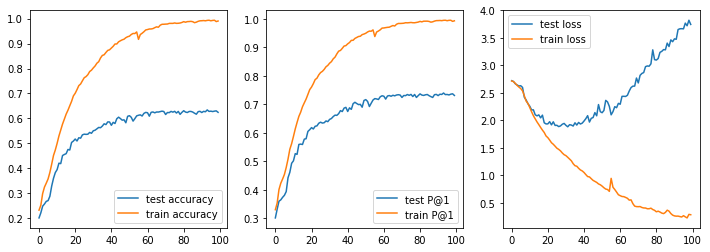

---------------------------------------------------------------------------------------------------- 

Hidden state size: 100
Train accuracy:0.999
Test accuracy:0.621
Train P@1:0.999
Test P@1:0.726
Train loss:0.141
Test loss:1.935


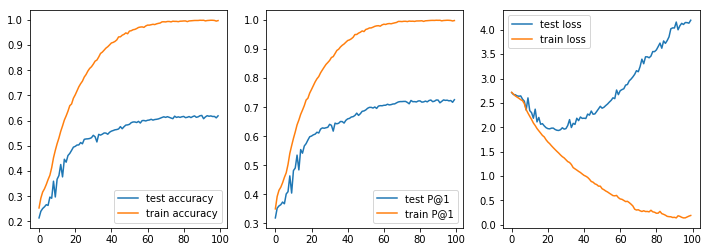

---------------------------------------------------------------------------------------------------- 

Hidden state size: 150
Train accuracy:1.000
Test accuracy:0.606
Train P@1:1.000
Test P@1:0.711
Train loss:0.051
Test loss:1.996


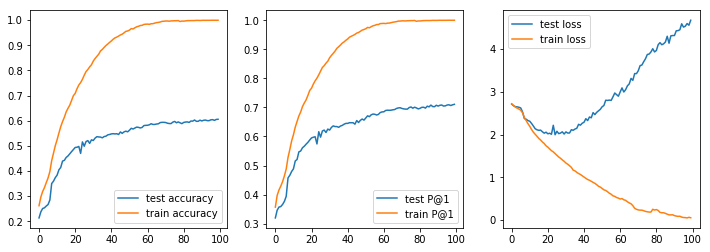

---------------------------------------------------------------------------------------------------- 

Hidden state size: 200
Train accuracy:1.000
Test accuracy:0.581
Train P@1:1.000
Test P@1:0.681
Train loss:0.045
Test loss:2.012


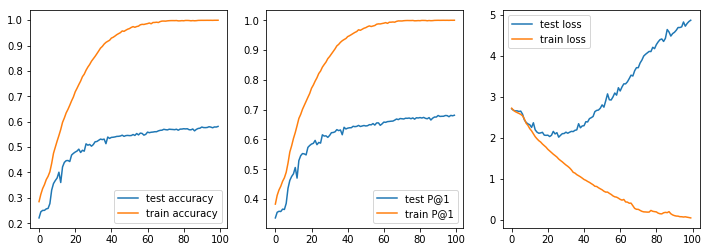

---------------------------------------------------------------------------------------------------- 



In [26]:
f = stats(biAttn_tst, biAttn_trn, epochs=100)

In [27]:
arr = []
for i, num_hidden in enumerate([50, 100, 150, 200]):
    arr.append([num_hidden,
               max(np.array(biAttn_tst[i])[:,0]), 
               max(np.array(biAttn_trn[i])[:,0]), 
               max(np.array(biAttn_tst[i])[:,1]), 
               max(np.array(biAttn_trn[i])[:,1]), 
               min(np.array(biAttn_tst[i])[:,2]), 
               min(np.array(biAttn_trn[i])[:,2])])
print(tabulate(arr, headers=['Hidden Dim', 'Test Accuracy', 'Train Accuracy', 'Test P@1', 'Train P@1', 'Test Loss',  'Train Loss'], tablefmt="fancy_grid"))

╒══════════════╤═════════════════╤══════════════════╤════════════╤═════════════╤═════════════╤══════════════╕
│   Hidden Dim │   Test Accuracy │   Train Accuracy │   Test P@1 │   Train P@1 │   Test Loss │   Train Loss │
╞══════════════╪═════════════════╪══════════════════╪════════════╪═════════════╪═════════════╪══════════════╡
│           50 │        0.634141 │         0.993283 │   0.73968  │    0.995455 │     1.88176 │    0.224759  │
├──────────────┼─────────────────┼──────────────────┼────────────┼─────────────┼─────────────┼──────────────┤
│          100 │        0.620707 │         0.998502 │   0.725758 │    0.999192 │     1.9345  │    0.140628  │
├──────────────┼─────────────────┼──────────────────┼────────────┼─────────────┼─────────────┼──────────────┤
│          150 │        0.605539 │         0.999562 │   0.710522 │    0.999764 │     1.99589 │    0.0510384 │
├──────────────┼─────────────────┼──────────────────┼────────────┼─────────────┼─────────────┼──────────────┤
│         